In [1]:
%pip install "chronos-forecasting[extras]>=2.2" matplotlib pandas

INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # nếu không có GPU thì bỏ dòng này

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load model
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-2",
    device_map="cuda"  # nếu không có GPU: dùng "cpu"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [ ]:
csv_path = "https://raw.githubusercontent.com/phido0410/chronos_for_crypto/refs/heads/main/feature_engineering/BTCUSDT_1d_fe.csv"

df = pd.read_csv(csv_path)

# Chuẩn hoá kiểu thời gian & sort cho chắc chắn
df["open_time"] = pd.to_datetime(df["open_time"])
df = df.sort_values("open_time")

# Thêm id cho chuỗi; nếu sau này có nhiều coin, mỗi coin = 1 id khác nhau
df["id"] = "BTCUSDT"

# Giữ lại các cột cần thiết và rename cho khớp chuẩn Chronos
df = df[["id", "open_time", "close", "  "]]
df = df.rename(columns={"open_time": "timestamp", "close": "target"})

print(df.head())
print(df.dtypes)


        id  timestamp   target     open     high      low       volume  \
0  BTCUSDT 2017-08-31  4724.89  4555.14  4745.42  4555.14   556.956802   
1  BTCUSDT 2017-09-01  4834.91  4689.89  4885.55  4654.88   560.666366   
2  BTCUSDT 2017-09-02  4472.14  4796.16  4939.19  4286.87   929.148595   
3  BTCUSDT 2017-09-03  4509.08  4508.50  4714.76  4298.33   691.216198   
4  BTCUSDT 2017-09-04  4100.11  4505.00  4527.49  3972.51  1394.644614   

         rsi  pct_change  
0  36.960842    3.726559  
1  41.058493    2.328520  
2  33.358714   -7.503139  
3  34.701566    0.826003  
4  27.979485   -9.069921  
id                    object
timestamp     datetime64[ns]
target               float64
open                 float64
high                 float64
low                  float64
volume               float64
rsi                  float64
pct_change           float64
dtype: object


In [4]:
prediction_length = 30  # số ngày muốn dự báo

assert len(df) > prediction_length, "Chuỗi phải dài hơn prediction_length."

context_df = df.iloc[:-prediction_length].copy()
test_df    = df.iloc[-prediction_length:].copy()

# future_df: covariates tương lai (cho 30 ngày sắp tới)
# => dùng test_df nhưng bỏ cột target (vì target là thứ ta muốn dự báo)
future_df = test_df.drop(columns=["target"])

print("context_df shape:", context_df.shape)
print("future_df shape:", future_df.shape)
print("test_df shape:", test_df.shape)


context_df shape: (2992, 9)
future_df shape: (30, 8)
test_df shape: (30, 9)


In [5]:
crypto_pred_df = pipeline.predict_df(
    df=context_df,
    future_df=future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],  # interval không chắc chắn
    id_column="id",
    timestamp_column="timestamp",
    target="target",
)

crypto_pred_df.head()


,id,timestamp,target_name,predictions,0.1,0.5,0.9
0,BTCUSDT,2025-11-09,target,103800.875000,101491.000000,103800.875000,106241.515625
1,BTCUSDT,2025-11-10,target,103873.250000,101986.218750,103873.250000,106066.296875
2,BTCUSDT,2025-11-11,target,103125.296875,101003.390625,103125.296875,104981.765625
3,BTCUSDT,2025-11-12,target,101503.093750,99609.429688,101503.093750,104079.562500
4,BTCUSDT,2025-11-13,target,99702.445312,98044.296875,99702.445312,101676.984375


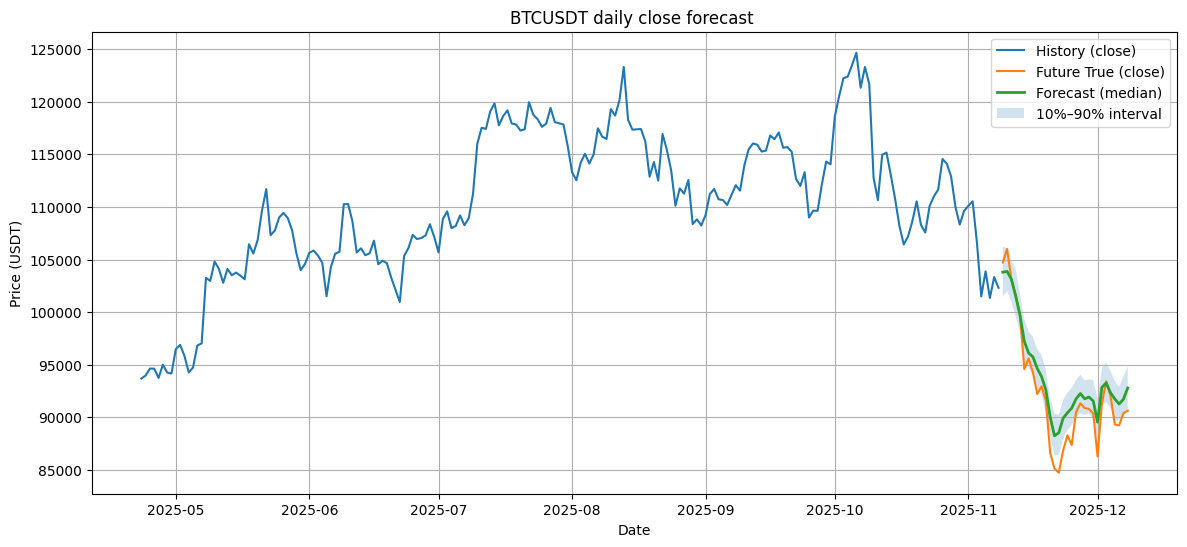

In [6]:
def plot_crypto_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    history_length: int = 200,
    id_value: str = "BTCUSDT",
    target_column: str = "target",
    id_column: str = "id",
    timestamp_column: str = "timestamp",
    title_suffix: str = "",
):
    # Lấy chuỗi lịch sử
    ts_context = (
        context_df.query(f"{id_column} == @id_value")
        .set_index(timestamp_column)[target_column]
    )

    # Lấy phần dự báo
    ts_pred = (
        pred_df.query(f"{id_column} == @id_value and target_name == @target_column")
        .set_index(timestamp_column)[["0.1", "predictions", "0.9"]]
    )

    # Ground truth tương lai (30 ngày cuối)
    ts_test = (
        test_df.query(f"{id_column} == @id_value")
        .set_index(timestamp_column)[target_column]
    )

    # Lấy history_length ngày gần nhất của context để plot cho gọn
    ts_context_tail = ts_context.iloc[-history_length:]

    plt.figure(figsize=(14, 6))

    # Lịch sử
    plt.plot(ts_context_tail.index, ts_context_tail.values, label="History (close)", linewidth=1.5)

    # Ground truth tương lai
    plt.plot(ts_test.index, ts_test.values, label="Future True (close)", linewidth=1.5)

    # Dự báo median
    plt.plot(ts_pred.index, ts_pred["predictions"].values, label="Forecast (median)", linewidth=2)

    # Vùng interval 10%–90%
    plt.fill_between(
        ts_pred.index,
        ts_pred["0.1"].values,
        ts_pred["0.9"].values,
        alpha=0.2,
        label="10%–90% interval",
    )

    plt.title(f"BTCUSDT daily close forecast {title_suffix}")
    plt.xlabel("Date")
    plt.ylabel("Price (USDT)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_crypto_forecast(context_df, crypto_pred_df, test_df, history_length=200)


In [8]:
crypto_pred_no_cov_df = pipeline.predict_df(
    df=context_df[["id", "timestamp", "target"]],  # chỉ giữ id, time, target
    future_df=None,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="id",               # 🔧 thêm 3 dòng này
    timestamp_column="timestamp",
    target="target",
)


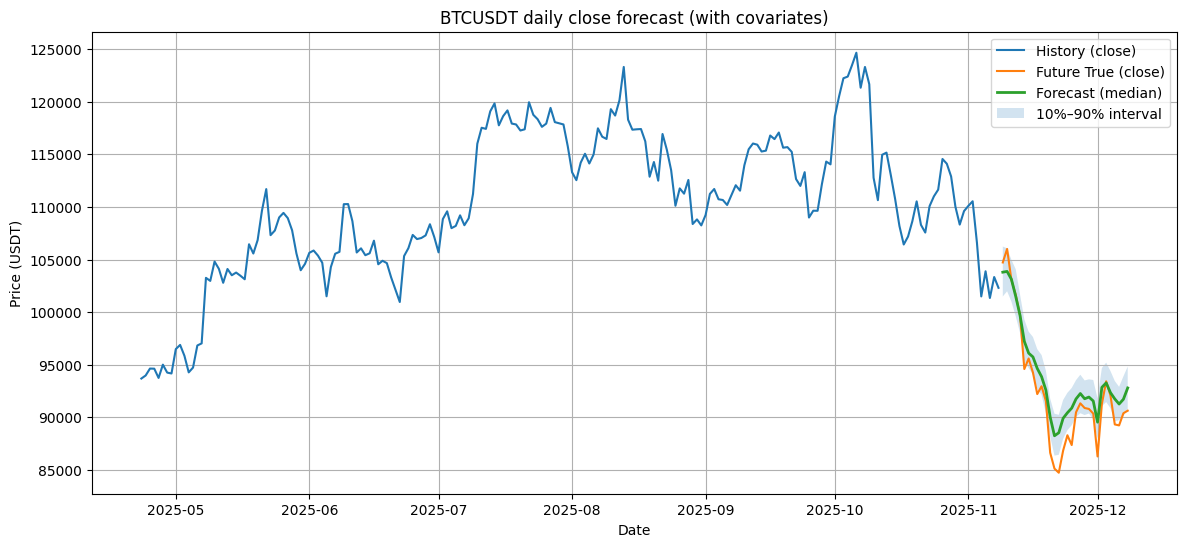

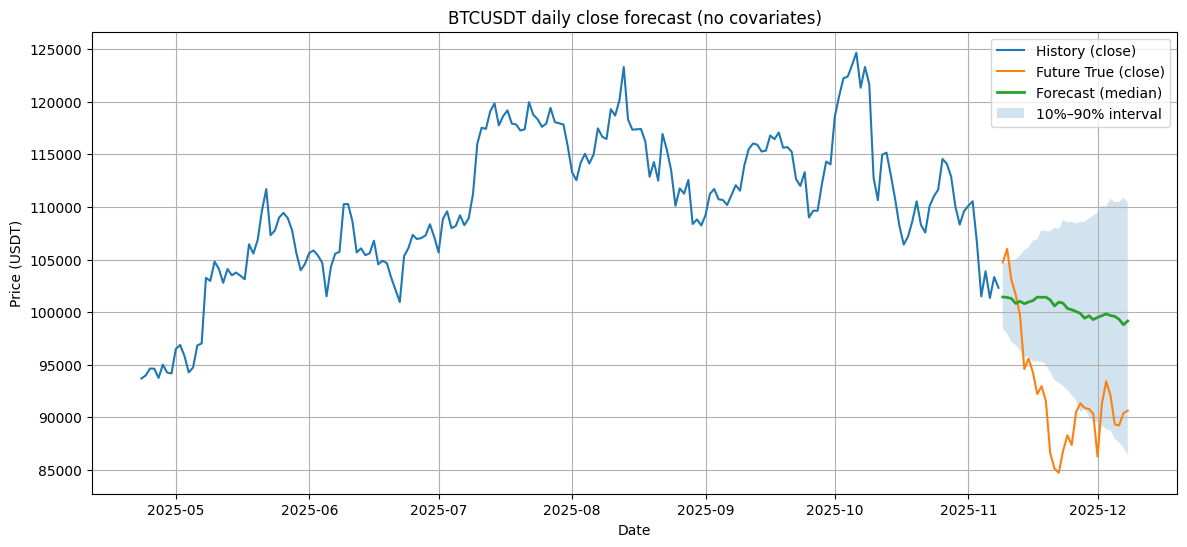

In [9]:
# 1) Forecast có covariates
plot_crypto_forecast(
    context_df=context_df,
    pred_df=crypto_pred_df,
    test_df=test_df,
    history_length=200,
    id_value="BTCUSDT",
    target_column="target",
    id_column="id",
    timestamp_column="timestamp",
    title_suffix="(with covariates)"
)

# 2) Forecast không covariates
plot_crypto_forecast(
    context_df=context_df[["id", "timestamp", "target"]],
    pred_df=crypto_pred_no_cov_df,
    test_df=test_df[["id", "timestamp", "target"]],
    history_length=200,
    id_value="BTCUSDT",
    target_column="target",
    id_column="id",
    timestamp_column="timestamp",
    title_suffix="(no covariates)"
)


In [13]:
import numpy as np
import pandas as pd

def compute_mae_rmse(
    test_df,
    pred_df,
    id_value="BTCUSDT",
    target_column="target",
    id_column="id",
    timestamp_column="timestamp",
):
    # True future
    ts_true = (
        test_df.query(f"{id_column} == @id_value")
        .set_index(timestamp_column)[target_column]
        .sort_index()
    )

    # Forecast (cột 'predictions' của Chronos)
    ts_pred = (
        pred_df.query(f"{id_column} == @id_value and target_name == @target_column")
        .set_index(timestamp_column)["predictions"]
        .sort_index()
    )

    # Căn thẳng index cho chắc
    ts_true, ts_pred = ts_true.align(ts_pred, join="inner")

    y_true = ts_true.values
    y_pred = ts_pred.values

    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    return mae, rmse


In [14]:
mae_base, rmse_base = compute_mae_rmse(
    test_df=test_df,
    pred_df=crypto_pred_no_cov_df,
)

mae_cov, rmse_cov = compute_mae_rmse(
    test_df=test_df,
    pred_df=crypto_pred_df,
)

print("Base (no covariates) - MAE:", mae_base, " RMSE:", rmse_base)
print("With covariates      - MAE:", mae_cov,  " RMSE:", rmse_cov)


Base (no covariates) - MAE: 8675.495281250001  RMSE: 9514.929514048641
With covariates      - MAE: 1664.7587604166667  RMSE: 2002.3549659168482
